# Relax take home challenge Solution
The data is available as two attached CSV files:

takehome_user_engagement. csv
takehome_users . csv
The data has the following two tables:
1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years. This table includes:
● name: the user's name
● object_id: the user's id
● email: email address
● creation_source: how their account was created. This takes on one
of 5 values:
○ PERSONAL_PROJECTS: invited to join another user's
personal workspace
○ GUEST_INVITE: invited to an organization as a guest
(limited permissions)
○ ORG_INVITE: invited to an organization (as a full member)
○ SIGNUP: signed up via the website
○ SIGNUP_GOOGLE_AUTH: signed up using Google
Authentication (using a Google email account for their login
id)
● creation_time: when they created their account
● last_session_creation_time: unix timestamp of last login
● opted_in_to_mailing_list: whether they have opted into receiving
marketing emails
● enabled_for_marketing_drip: whether they are on the regular
marketing email drip
● org_id: the organization (group of users) they belong to
● invited_by_user_id: which user invited them to join (if applicable).
2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day
that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday
period , identify which factors predict future user
adoption

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Section1: Load data

## 1.1 Load user csv file

In [2]:
# import user csv files
import chardet
with open("takehome_users.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ISO-8859-1', 'confidence': 0.7294372453287324, 'language': ''}

In [3]:
# read csv file
user_df = pd.read_csv("takehome_users.csv", encoding='ISO-8859-1')

In [4]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
user_df.shape

(12000, 10)

In [6]:
user_df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [7]:
user_df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

## 1.2 Load user engagement table

In [8]:
# import user engagement csv files
user_eng_df = pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])

In [9]:
user_eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
user_eng_df.shape

(207917, 3)

In [11]:
user_eng_df.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [12]:
# check the data types of each column
user_eng_df.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

## 1.3 Sort the user engagment table to find the frequency of user log-in in a week time frame

In [13]:
# set time_stamp as index
user_eng_df['wk'] = user_eng_df['time_stamp'].dt.week
user_eng_df_group = user_eng_df.groupby(['wk','user_id'])['time_stamp'].count().reset_index(name='freq')

In [14]:
user_eng_df_group.head()

,wk,user_id,freq
0,1,2,1
1,1,10,5
2,1,42,4
3,1,43,1
4,1,46,1


In [15]:
result = user_eng_df_group[user_eng_df_group.freq >= 3]

# only user ids matching criteria
user_ids = result.user_id.tolist()
user_ids_uniq = pd.Series(user_ids).unique()
print(user_ids_uniq)

[   10    42    63 ...  4134 10446 10335]


In [16]:
# Create a list with 1 represent adapoted user, 0 means not.
adopted_user_temp = np.zeros(len(user_df), dtype=int)
for i in range(len(user_df)):
    for j in user_ids_uniq:
        if user_df['object_id'][i] == j:
            adopted_user_temp[i] = 1   

In [17]:
# Add a target column as adopted_user to user_df table
user_df['adopted_user'] = adopted_user_temp

In [18]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [19]:
# Write out the new table to csv file to save the previous processing time
user_df.to_csv('users_new', index=False)

## 1.4  Feature Engineering

In [20]:
# Read the new Data
df = pd.read_csv('users_new')

In [21]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [22]:
# check the data type
df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted_user                    int64
dtype: object

In [23]:
# Check column contains null value or not
df.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                     0
dtype: int64

In [24]:
# dro column 'last_session_creation_time' and 'invited_by_user_id'
df = df.drop(['last_session_creation_time','invited_by_user_id'], axis=1)

In [25]:
# Transform creation time to month
df['first_session_month'] = pd.to_datetime(df['creation_time']).dt.month

In [26]:
df.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,first_session_month
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,0,4
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,1,11
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,0,3
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,0,5
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,0,1


In [27]:
df.dtypes

object_id                      int64
creation_time                 object
name                          object
email                         object
creation_source               object
opted_in_to_mailing_list       int64
enabled_for_marketing_drip     int64
org_id                         int64
adopted_user                   int64
first_session_month            int64
dtype: object

In [28]:
# One-Hot encode of the creation_source column
one_hot = pd.get_dummies(df['creation_source'], prefix='creation_source')
# Drop column as it is now encoded
df = df.drop('creation_source', axis=1)
# Join the encoded df
df = df.join(one_hot)
df

,object_id,creation_time,name,email,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,first_session_month,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1,0,11,0,4,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,0,0,1,1,11,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,0,0,94,0,3,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,0,0,1,0,5,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,0,0,193,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,0,0,89,0,9,0,1,0,0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,0,0,200,0,1,0,0,0,0,1
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,1,1,83,0,4,1,0,0,0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,0,0,6,0,5,0,0,1,0,0


In [29]:
# Drop some features for modeling, Column'last_session_creation_time' data has some problem, will be dropped out.
drop_cols = ['object_id','creation_time','name','email','org_id', 'first_session_month']
df = df.drop(drop_cols, axis=1)

In [30]:
df.dtypes

opted_in_to_mailing_list              int64
enabled_for_marketing_drip            int64
adopted_user                          int64
creation_source_GUEST_INVITE          uint8
creation_source_ORG_INVITE            uint8
creation_source_PERSONAL_PROJECTS     uint8
creation_source_SIGNUP                uint8
creation_source_SIGNUP_GOOGLE_AUTH    uint8
dtype: object

In [31]:
# Check if null value existed
df.isnull().sum()

opted_in_to_mailing_list              0
enabled_for_marketing_drip            0
adopted_user                          0
creation_source_GUEST_INVITE          0
creation_source_ORG_INVITE            0
creation_source_PERSONAL_PROJECTS     0
creation_source_SIGNUP                0
creation_source_SIGNUP_GOOGLE_AUTH    0
dtype: int64

# Section 2 EDA

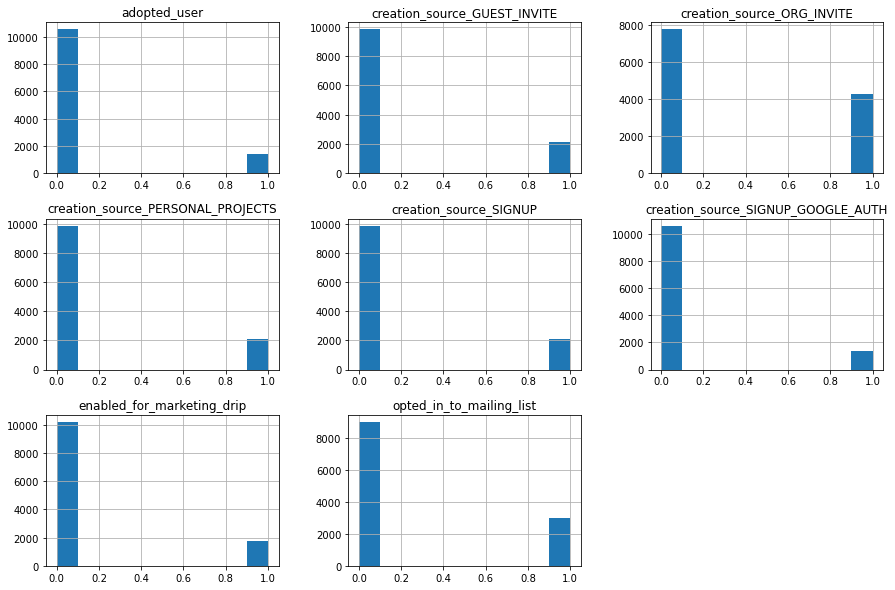

In [32]:
df.hist(figsize=(15,10))
plt.show()

### Among 12000 users there are only 1445 adopted_users. This data has a inbalanced datasets problem. will test under-sampling and over-sampling to see which one works better for the modeling results.

Class 0: 10555
Class 1: 1445
Proportion: 7.3 : 1


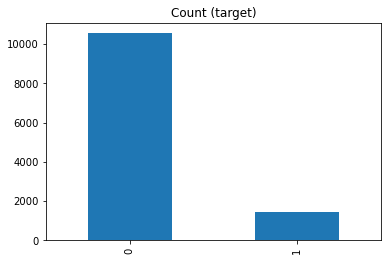

In [33]:
target_count = df.adopted_user.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

## 2.1 Random resampling the data

### 2.1.1 Undersampling class 0

In [34]:
# Clalss count
count_class_0, count_class_1 = df.adopted_user.value_counts()

# Divide data by class
df_class_0 = df[df['adopted_user'] == 0]
df_class_1 = df[df['adopted_user'] == 1]

Random under_sampling:
1    1445
0    1445
Name: adopted_user, dtype: int64


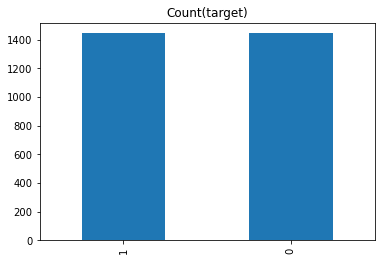

In [35]:
# Random under-sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under_sampling:')
print(df_under.adopted_user.value_counts())

df_under.adopted_user.value_counts().plot(kind='bar', title='Count(target)')

### 2.1.2 Oversampling class 1

Random over_sampling:
1    10555
0    10555
Name: adopted_user, dtype: int64


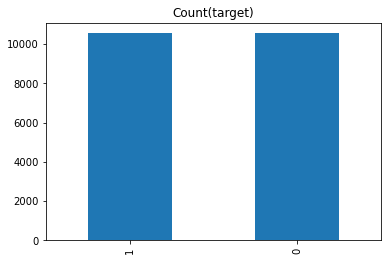

In [36]:
# Random over-sampling
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over_sampling:')
print(df_over.adopted_user.value_counts())

df_over.adopted_user.value_counts().plot(kind='bar', title='Count(target)')

## Tests show under sample and oversample has similiar result. For this exercise I will only use the oversampling data.

# Section 3 Modeling

## 3.1 Modeling on oversampled data

In [37]:
# Prepare data for modeling
X = df_over.drop('adopted_user', axis=1)
y = df_over.adopted_user

In [38]:
# Split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 111)

## 3.1.1 Random forest model

In [39]:
# Build random forest model
rf_model = RandomForestClassifier()
rf_result = rf_model.fit(X_train, y_train)
y_test_pred_rf = rf_result.predict(X_test)

### Model evaluation

The accuracy score is 0.5458708353071214
The confusion matrix is 
[[1523 1641]
 [1235 1934]]


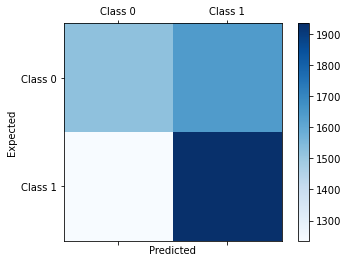

In [40]:
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
conf_mat_rf = confusion_matrix(y_test,y_test_pred_rf) 

def plot_conf_mat(arr):
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(arr, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

print("The accuracy score is {}".format(accuracy_rf))

print("The confusion matrix is \n{}".format(conf_mat_rf))

plot_conf_mat(conf_mat_rf)

## 3.1.2 model tuning

In [41]:
param_grid = {'n_estimators':[10, 50, 100],
               'criterion':['gini','entropy'],
               'max_depth':[20, 40, 60]}
rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf,param_grid, cv=5)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 40, 60],
                         'n_estimators': [10, 50, 100]})

In [42]:
# Print the best score and best parameters
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.5571496672001539
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 10}


In [43]:
rf_final = RandomForestClassifier(criterion='gini', n_estimators=10, max_depth = 40, random_state = 1234)
rf_final_result = rf_final.fit(X_train, y_train)
y_test_pred_rf_final = rf_final_result.predict(X_test)

In [44]:
 print(classification_report(y_test, y_test_pred_rf_final))

              precision    recall  f1-score   support

           0       0.55      0.47      0.51      3164
           1       0.54      0.62      0.58      3169

    accuracy                           0.55      6333
   macro avg       0.55      0.55      0.54      6333
weighted avg       0.55      0.55      0.54      6333



The accuracy score is 0.5450813200694773
The confusion matrix is 
[[1486 1678]
 [1203 1966]]


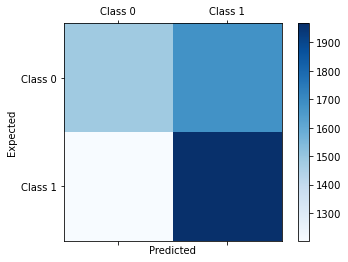

In [45]:
accuracy_rf_final = accuracy_score(y_test, y_test_pred_rf_final)
conf_mat_rf_final = confusion_matrix(y_test,y_test_pred_rf_final) 

print("The accuracy score is {}".format(accuracy_rf_final))

print("The confusion matrix is \n{}".format(conf_mat_rf_final))

plot_conf_mat(conf_mat_rf_final)

In [46]:
# create a dataframe of feature importance from gb_final model
features = pd.DataFrame({'rf_final':rf_final.feature_importances_}, index=X.columns)

# Sort by highest values
features.sort_values('rf_final', ascending=False)[:20]


,rf_final
creation_source_PERSONAL_PROJECTS,0.504092
creation_source_GUEST_INVITE,0.210145
creation_source_ORG_INVITE,0.087283
creation_source_SIGNUP_GOOGLE_AUTH,0.063828
enabled_for_marketing_drip,0.052451
creation_source_SIGNUP,0.051603
opted_in_to_mailing_list,0.030598


# Conclusion
1. This dataset needs to do more feature engineering work. 

2. The data set has inbalanced class problem, the adopted user only account about 1/10 of total users (12000). Both oversampling and undersampling are applied to the data.

3. Based on random forest modeling, it looks if the user joined the program through personal projects, they are more likely to be an adpoted user.